In [33]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import wandb

# Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load data
print("Loading data...")
df = pd.read_parquet('../data/hackernews_full_data.parquet')
print(f"Loaded {len(df):,} stories")

# Use a sample for faster processing
df_sample = df.sample(n=500000, random_state=42).copy()

Using device: cpu
Loading data...
Loaded 4,902,536 stories


In [35]:
df_sample.head()

,id,by,time,url,score,title,descendants
3942193,2488405,icefox,2011-04-27 05:36:18,http://zrusin.blogspot.com/2011/04/apitrace.html,7,OpenGL and Direct3D crazy GUI debugger via API...,1.0
3221796,22654492,frereubu,2020-03-22 12:32:51,https://ourworldindata.org/coronavirus,1,Coronavirus Disease (Covid-19) – Statistics an...,0.0
35269,151269,jasonlbaptiste,2008-03-31 21:17:01,None,1,The April Fools Thread- List of April Fools Jo...,0.0
2263485,1440203,123icebox,2010-06-17 21:11:46,http://www.primarygames.com/arcade/virtualworl...,1,Arcade: Virtual Worlds - PrimaryGames.com - Fr...,-1.0
3245845,22832574,onetimemanytime,2020-04-10 14:01:09,https://news.yahoo.com/wuhan-rent-protest-show...,1,Wuhan Rent Protest Shows Unrest Brewing in Chi...,0.0


In [13]:
# Setup wandb directories
import os
os.environ['WANDB_DIR'] = '/tmp/wandb'
os.environ['WANDB_CACHE_DIR'] = '/tmp/wandb_cache'
os.environ['WANDB_DATA_DIR'] = '/tmp/wandb_data'
os.makedirs('/tmp/wandb', exist_ok=True)
os.makedirs('/tmp/wandb_cache', exist_ok=True) 
os.makedirs('/tmp/wandb_data', exist_ok=True)

print("✅ Wandb setup complete!")

✅ Wandb setup complete!


In [14]:
# Check the type of the 'time' column
print(df_sample['time'].head())
print(df_sample['time'].dtype)

# Convert to datetime if not already
df_sample['timestamp'] = pd.to_datetime(df_sample['time'], errors='coerce')

# Check for any failed conversions (NaT)
print(df_sample['timestamp'].isnull().sum(), "rows could not be converted to datetime.")
print(df_sample[['time', 'timestamp']].head())

3942193   2011-04-27 05:36:18
3221796   2020-03-22 12:32:51
35269     2008-03-31 21:17:01
2263485   2010-06-17 21:11:46
3245845   2020-04-10 14:01:09
Name: time, dtype: datetime64[ns]
datetime64[ns]
0 rows could not be converted to datetime.
                       time           timestamp
3942193 2011-04-27 05:36:18 2011-04-27 05:36:18
3221796 2020-03-22 12:32:51 2020-03-22 12:32:51
35269   2008-03-31 21:17:01 2008-03-31 21:17:01
2263485 2010-06-17 21:11:46 2010-06-17 21:11:46
3245845 2020-04-10 14:01:09 2020-04-10 14:01:09


In [ ]:
print("Calculating user and title features...")

# User features are removed as requested to simplify the model.
df_featured = df_sample.copy()

# Title feature
df_featured['word_count'] = df_featured['title'].str.split().str.len()
df_featured['word_count'] = df_featured['word_count'].fillna(0)

print("Features calculated.")

# Apply log1p transformation to the target variable
df_featured['score_log'] = np.log1p(df_featured['score'])


# --- Time-based features (with cyclical transformation) ---
print("Adding time-based features...")
df_featured['timestamp'] = pd.to_datetime(df_featured['timestamp'])
df_featured['hour_of_day'] = df_featured['timestamp'].dt.hour
df_featured['day_of_week'] = df_featured['timestamp'].dt.dayofweek

# Cyclical features for time
df_featured['hour_sin'] = np.sin(2 * np.pi * df_featured['hour_of_day']/24)
df_featured['hour_cos'] = np.cos(2 * np.pi * df_featured['hour_of_day']/24)
df_featured['day_sin'] = np.sin(2 * np.pi * df_featured['day_of_week']/7)
df_featured['day_cos'] = np.cos(2 * np.pi * df_featured['day_of_week']/7)
print("Time-based features added.")

# --- NEW: URL (Domain) features ---
from urllib.parse import urlparse
print("Adding URL-based features...")

# Handle missing URLs, assuming they are self-posts
df_featured['url'] = df_featured['url'].fillna('self_post')

def extract_domain(url):
    if url == 'self_post' or url is None:
        return 'self_post'
    try:
        # Remove 'www.' prefix for consistency
        domain = urlparse(url).netloc.replace('www.', '')
        if domain == '': # handles cases like relative links or javascript:
            return 'no_domain'
        return domain
    except Exception:
        return 'parse_error'

df_featured['domain'] = df_featured['url'].apply(extract_domain)

# Identify top domains to prevent too many one-hot features
top_domains = df_featured['domain'].value_counts().nlargest(20).index.tolist()

# Create one-hot encoded features for top domains
for domain in top_domains:
    df_featured[f'domain_{domain}'] = (df_featured['domain'] == domain).astype(int)

# Group other domains into a single feature
df_featured['domain_other'] = (~df_featured['domain'].isin(top_domains) & (df_featured['domain'] != 'self_post')).astype(int)
print(f"Added one-hot features for top {len(top_domains)} domains.")

Calculating user and title features...
Features calculated.
Adding time-based features...
Time-based features added.
Adding URL-based features...
Added one-hot features for top 20 domains.


In [16]:
# Get the list of top domains again to make this cell runnable independently
top_domains = df_featured['domain'].value_counts().nlargest(20).index.tolist()
domain_features = [f'domain_{domain}' for domain in top_domains] + ['domain_other']

features = [
    #'user_post_count_pt', 
    #'user_median_score_pt', 
    'word_count', 
    # Using cyclical time features instead of raw hour/day
    'hour_sin',
    'hour_cos',
    'day_sin',
    'day_cos'
] + domain_features

target_log = 'score_log'
target_orig = 'score'

X = df_featured[features]
y_df = df_featured[[target_log, target_orig]]

X_train, X_test, y_train_df, y_test_df = train_test_split(
    X, y_df, test_size=0.2, random_state=42
)

y_train_log = y_train_df[target_log].values.reshape(-1, 1)
y_test_log = y_test_df[target_log].values.reshape(-1, 1)
y_test_orig = y_test_df[target_orig].values

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert to PyTorch Tensors
X_train_tensor = torch.FloatTensor(X_train_scaled).to(device)
y_train_tensor = torch.FloatTensor(y_train_log).to(device)
X_test_tensor = torch.FloatTensor(X_test_scaled).to(device)
y_test_tensor = torch.FloatTensor(y_test_log).to(device)

print(f"Data split and scaled. Training samples: {len(X_train_scaled)}")

Data split and scaled. Training samples: 400000


In [17]:
# Hyperparameter Sweep Configuration
sweep_config = {
    'method': 'bayes',  # Bayesian optimization for smarter search
    'metric': {
        'name': 'test_r2_score',  # Focus on R² score on the original scale
        'goal': 'maximize'   # We want to maximize R²
    },
    'parameters': {
        'learning_rate': {
            'distribution': 'log_uniform_values',
            'min': 1e-5,
            'max': 1e-1
        },
        'batch_size': {
            'values': [256, 512, 1024, 2048]
        },
        'optimizer': {
            'values': ['adam', 'sgd', 'adamw']
        },
        'layer_1_size': {
            'values': [64, 128, 256]
        },
        'layer_2_size': {
            'values': [32, 64, 128]
        },
        'dropout_rate': {
            'distribution': 'uniform',
            'min': 0.1,
            'max': 0.5
        },
        'epochs': {
            'values': [15, 25, 30]
        },
        'weight_decay': {
            'distribution': 'log_uniform_values',
            'min': 1e-6,
            'max': 1e-2
        }
    }
}

print("🎯 Sweep configuration ready!")

🎯 Sweep configuration ready!


In [18]:
class SimplePredictor(nn.Module):
    def __init__(self, input_dim, layer_1_size=64, layer_2_size=32, dropout_rate=0.2):
        super(SimplePredictor, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, layer_1_size),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(layer_1_size, layer_2_size),
            nn.ReLU(),
            nn.Linear(layer_2_size, 1)
        )
    def forward(self, x):
        return self.model(x)

print("✅ Parameterized SimplePredictor model ready!")

✅ Parameterized SimplePredictor model ready!


In [19]:
# Training function for wandb
def train_model():
    """Main training function for a single wandb run."""
    run = wandb.init()
    config = wandb.config
    
    # Dataloader
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
    
    # Model
    input_dim = X_train_scaled.shape[1]
    model = SimplePredictor(
        input_dim,
        layer_1_size=config.layer_1_size,
        layer_2_size=config.layer_2_size,
        dropout_rate=config.dropout_rate
    ).to(device)
    
    # Optimizer
    if config.optimizer == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)
    elif config.optimizer == 'adamw':
        optimizer = optim.AdamW(model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)
    else: # sgd
        optimizer = optim.SGD(model.parameters(), lr=config.learning_rate, momentum=0.9, weight_decay=config.weight_decay)

    criterion = nn.MSELoss()
    
    # Training Loop
    best_test_loss = float('inf')
    for epoch in range(config.epochs):
        model.train()
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

        # Evaluation at end of epoch
        model.eval()
        with torch.no_grad():
            train_outputs = model(X_train_tensor)
            train_loss = criterion(train_outputs, y_train_tensor).item()
            test_outputs = model(X_test_tensor)
            test_loss = criterion(test_outputs, y_test_tensor).item()
        
        # Log metrics to wandb
        wandb.log({
            "epoch": epoch,
            "train_loss_log": train_loss,
            "test_loss_log": test_loss
        })
        
        best_test_loss = min(best_test_loss, test_loss)
        
    # Final Evaluation (on original scale)
    model.eval()
    with torch.no_grad():
        y_pred_log = model(X_test_tensor).cpu().numpy().flatten()
    
    y_pred_orig = np.expm1(y_pred_log)
    
    r2 = r2_score(y_test_orig, y_pred_orig)
    rmse = np.sqrt(mean_squared_error(y_test_orig, y_pred_orig))
    
    
    # Log final metrics for the sweep
    wandb.log({
        "test_r2_score": r2,
        "test_rmse": rmse,
        "best_test_loss_log": best_test_loss
    })
    
    run.finish()

print("✅ Training function for wandb sweep is ready!")

✅ Training function for wandb sweep is ready!


In [20]:
# Run the sweep (this will take a while!)
# It will run 10 different combinations of parameters.
print("🚀 Starting hyperparameter sweep...")

sweep_id = wandb.sweep(sweep_config, project="hackernews-score-predictor")
print(f"📊 Sweep ID: {sweep_id}")
print(f"🌐 Monitor at: https://wandb.ai/{wandb.api.default_entity}/hackernews-score-predictor/sweeps/{sweep_id}")

# UNCOMMENT THE LINE BELOW TO RUN THE SWEEP
wandb.agent(sweep_id, train_model, count=10) 

print("\n✅ Sweep setup complete. Uncomment the agent line to run.")

🚀 Starting hyperparameter sweep...
Create sweep with ID: 6piipew8
Sweep URL: https://wandb.ai/joaopaesteves99-opensc/hackernews-score-predictor/sweeps/6piipew8
📊 Sweep ID: 6piipew8
🌐 Monitor at: https://wandb.ai/joaopaesteves99-opensc/hackernews-score-predictor/sweeps/6piipew8


wandb: Agent Starting Run: mxm6jgip with config:
wandb: 	batch_size: 1024
wandb: 	dropout_rate: 0.4142549673933094
wandb: 	epochs: 30
wandb: 	layer_1_size: 128
wandb: 	layer_2_size: 64
wandb: 	learning_rate: 1.5941249798534578e-05
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.00135893144618865


best_test_loss_log,▁
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
test_loss_log,█▅▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_r2_score,▁
test_rmse,▁
train_loss_log,█▅▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
best_test_loss_log,1.25749
epoch,29
test_loss_log,1.25774
test_r2_score,-0.03385
test_rmse,61.01618


wandb: Agent Starting Run: qgctqdmr with config:
wandb: 	batch_size: 256
wandb: 	dropout_rate: 0.39453894828162606
wandb: 	epochs: 30
wandb: 	layer_1_size: 64
wandb: 	layer_2_size: 32
wandb: 	learning_rate: 1.7647228535739167e-05
wandb: 	optimizer: adamw
wandb: 	weight_decay: 3.335262802442914e-05


best_test_loss_log,▁
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
test_loss_log,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_r2_score,▁
test_rmse,▁
train_loss_log,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
best_test_loss_log,1.25698
epoch,29
test_loss_log,1.25711
test_r2_score,-0.03371
test_rmse,61.01185


wandb: Agent Starting Run: z8r0xumr with config:
wandb: 	batch_size: 1024
wandb: 	dropout_rate: 0.2611039257792485
wandb: 	epochs: 25
wandb: 	layer_1_size: 256
wandb: 	layer_2_size: 32
wandb: 	learning_rate: 0.001170585916801457
wandb: 	optimizer: adamw
wandb: 	weight_decay: 3.329372020121797e-06


wandb: Network error (ConnectionError), entering retry loop.


best_test_loss_log,▁
epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
test_loss_log,█▃▃▂▂▂▁▇▂▂▁▁▄▁▁▁▂▂▁▂▁▂▁▂▁
test_r2_score,▁
test_rmse,▁
train_loss_log,█▃▃▂▂▂▂█▂▂▂▂▅▁▁▁▂▂▁▁▁▂▁▁▁
best_test_loss_log,1.25412
epoch,24
test_loss_log,1.25468
test_r2_score,-0.03246
test_rmse,60.97497


wandb: Agent Starting Run: okx5vcvj with config:
wandb: 	batch_size: 2048
wandb: 	dropout_rate: 0.41389268093273246
wandb: 	epochs: 30
wandb: 	layer_1_size: 64
wandb: 	layer_2_size: 128
wandb: 	learning_rate: 0.006574988584707695
wandb: 	optimizer: sgd
wandb: 	weight_decay: 1.997385077330383e-05


best_test_loss_log,▁
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
test_loss_log,▆▅▆▅▃█▄▄▃▅▁▅▃▃▄▃▄▃▂▃▃▃▄▂▂▂▃▄▄▂
test_r2_score,▁
test_rmse,▁
train_loss_log,▆▅▆▅▃█▄▄▃▅▁▅▃▃▃▂▄▃▂▃▃▂▄▁▂▁▃▃▃▁
best_test_loss_log,1.25731
epoch,29
test_loss_log,1.25787
test_r2_score,-0.03416
test_rmse,61.02532


wandb: Agent Starting Run: sx0jfggl with config:
wandb: 	batch_size: 2048
wandb: 	dropout_rate: 0.15019204856209056
wandb: 	epochs: 25
wandb: 	layer_1_size: 256
wandb: 	layer_2_size: 32
wandb: 	learning_rate: 0.002468147027365075
wandb: 	optimizer: sgd
wandb: 	weight_decay: 2.309411687356101e-06


best_test_loss_log,▁
epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
test_loss_log,██▆▅▅▄▄▅▃▃▃▃▃▂▂▃▂▂▂▂▁▁▂▂▁
test_r2_score,▁
test_rmse,▁
train_loss_log,██▆▅▅▄▄▅▃▄▄▃▃▂▂▃▂▂▂▂▁▁▂▂▁
best_test_loss_log,1.25558
epoch,24
test_loss_log,1.25558
test_r2_score,-0.03328
test_rmse,60.99915


wandb: Agent Starting Run: m5xzs50c with config:
wandb: 	batch_size: 1024
wandb: 	dropout_rate: 0.2728764986683999
wandb: 	epochs: 25
wandb: 	layer_1_size: 256
wandb: 	layer_2_size: 64
wandb: 	learning_rate: 0.0027283761985306657
wandb: 	optimizer: adamw
wandb: 	weight_decay: 2.183708485720008e-05


best_test_loss_log,▁
epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
test_loss_log,▅█▂▄▃▂▄▂▂▂▁▁▃▂▂▂▁▁▂▁▁▁▁▁▂
test_r2_score,▁
test_rmse,▁
train_loss_log,▅█▂▄▃▂▄▂▂▂▁▁▃▂▂▂▁▂▁▁▁▁▁▁▁
best_test_loss_log,1.25345
epoch,24
test_loss_log,1.25495
test_r2_score,-0.03365
test_rmse,61.01016


wandb: Agent Starting Run: 4bfp8t51 with config:
wandb: 	batch_size: 512
wandb: 	dropout_rate: 0.19366429712194205
wandb: 	epochs: 30
wandb: 	layer_1_size: 256
wandb: 	layer_2_size: 64
wandb: 	learning_rate: 0.001529403289858678
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0038099090520785214


best_test_loss_log,▁
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
test_loss_log,█▆▅▆▄▃▃▃▄▃▂▂▃▄▃▂▂▂▂▁▂▄▂▂▁▁▂▁▁▁
test_r2_score,▁
test_rmse,▁
train_loss_log,█▆▅▆▄▃▃▃▄▃▂▂▃▃▃▂▂▂▂▂▁▄▂▂▁▁▁▁▁▁
best_test_loss_log,1.25534
epoch,29
test_loss_log,1.25534
test_r2_score,-0.03294
test_rmse,60.98924


wandb: Agent Starting Run: ayhvo5mm with config:
wandb: 	batch_size: 256
wandb: 	dropout_rate: 0.4453664565396888
wandb: 	epochs: 15
wandb: 	layer_1_size: 256
wandb: 	layer_2_size: 64
wandb: 	learning_rate: 1.6305579488087907e-05
wandb: 	optimizer: sgd
wandb: 	weight_decay: 8.354366518481734e-05


best_test_loss_log,▁
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
test_loss_log,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁
test_r2_score,▁
test_rmse,▁
train_loss_log,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁
best_test_loss_log,1.25995
epoch,14
test_loss_log,1.25995
test_r2_score,-0.03402
test_rmse,61.02106


wandb: Agent Starting Run: ltpolfyk with config:
wandb: 	batch_size: 2048
wandb: 	dropout_rate: 0.318231984357067
wandb: 	epochs: 30
wandb: 	layer_1_size: 128
wandb: 	layer_2_size: 64
wandb: 	learning_rate: 0.07901443179909735
wandb: 	optimizer: adam
wandb: 	weight_decay: 6.218408672183103e-06


best_test_loss_log,▁
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
test_loss_log,█▃▂▂▂▁▆▁▁▂▂▂▃▂▃▂▇▂▂▅▃▅▂▃▄▅▇▆▅▇
test_r2_score,▁
test_rmse,▁
train_loss_log,█▃▂▂▁▁▆▁▁▂▁▁▃▁▂▂▇▂▂▅▃▅▂▃▄▅▇▆▅▇
best_test_loss_log,1.25623
epoch,29
test_loss_log,1.26419
test_r2_score,-0.03275
test_rmse,60.98354


wandb: Agent Starting Run: mw23xj6q with config:
wandb: 	batch_size: 1024
wandb: 	dropout_rate: 0.2722553482192236
wandb: 	epochs: 15
wandb: 	layer_1_size: 64
wandb: 	layer_2_size: 32
wandb: 	learning_rate: 6.731245644798552e-05
wandb: 	optimizer: sgd
wandb: 	weight_decay: 1.6734860240044057e-05


best_test_loss_log,▁
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
test_loss_log,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁
test_r2_score,▁
test_rmse,▁
train_loss_log,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁
best_test_loss_log,1.26315
epoch,14
test_loss_log,1.26315
test_r2_score,-0.03423
test_rmse,61.0274



✅ Sweep setup complete. Uncomment the agent line to run.


In [31]:
# Get the best parameters from a completed sweep
def get_best_parameters(sweep_id):
    api = wandb.Api()
    try:
        sweep = api.sweep(f"{wandb.api.default_entity}/hackernews-score-predictor/{sweep_id}")
        print(sweep_id)
    except wandb.errors.CommError:
        print(f"❌ Sweep '{sweep_id}' not found. Please check the sweep ID and project name.")
        return None
    
    # Get the best run based on the metric we defined (test_r2_score)
    best_run = sweep.best_run()
    
    if best_run:
        print(f"\n🏆 BEST PARAMETERS (R²: {best_run.summary.get('test_r2_score', 'N/A'):.4f})")
        print("=" * 50)
        
        best_config = {}
        for key, value in best_run.config.items():
            best_config[key] = value
            print(f"{key:15}: {value}")
        
        print("=" * 50)
        return best_config
    else:
        print("❌ No successful runs found in the sweep!")
        return None

# --- IMPORTANT ---
best_config = get_best_parameters("6piipew8")
best_config['epochs'] = 100
print(best_config)

wandb: Sorting runs by -summary_metrics.test_r2_score


6piipew8

🏆 BEST PARAMETERS (R²: -0.0325)
epochs         : 25
optimizer      : adamw
batch_size     : 1024
dropout_rate   : 0.2611039257792485
layer_1_size   : 256
layer_2_size   : 32
weight_decay   : 3.329372020121797e-06
learning_rate  : 0.001170585916801457
{'epochs': 100, 'optimizer': 'adamw', 'batch_size': 1024, 'dropout_rate': 0.2611039257792485, 'layer_1_size': 256, 'layer_2_size': 32, 'weight_decay': 3.329372020121797e-06, 'learning_rate': 0.001170585916801457}


🚀 Training final model with best parameters...


epoch,▁█
final_test_loss,█▁
final_train_loss,█▁
epoch,1
final_test_loss,1.25711
final_train_loss,1.26453


Epoch  1/100 | Train Loss: 1.311715 | Test Loss: 1.258186
Epoch  2/100 | Train Loss: 1.259301 | Test Loss: 1.261140
Epoch  3/100 | Train Loss: 1.257156 | Test Loss: 1.259302
Epoch  4/100 | Train Loss: 1.256215 | Test Loss: 1.257768
Epoch  5/100 | Train Loss: 1.254679 | Test Loss: 1.255056
Epoch  6/100 | Train Loss: 1.253978 | Test Loss: 1.254450
Epoch  7/100 | Train Loss: 1.253622 | Test Loss: 1.254725
Epoch  8/100 | Train Loss: 1.252464 | Test Loss: 1.254696
Epoch  9/100 | Train Loss: 1.252707 | Test Loss: 1.255673
Epoch 10/100 | Train Loss: 1.251862 | Test Loss: 1.255875
Epoch 11/100 | Train Loss: 1.251866 | Test Loss: 1.255333
Epoch 12/100 | Train Loss: 1.250803 | Test Loss: 1.254639
Epoch 13/100 | Train Loss: 1.250709 | Test Loss: 1.257421
Epoch 14/100 | Train Loss: 1.250989 | Test Loss: 1.256242
Epoch 15/100 | Train Loss: 1.250615 | Test Loss: 1.254770
Epoch 16/100 | Train Loss: 1.250218 | Test Loss: 1.254007
Epoch 17/100 | Train Loss: 1.250100 | Test Loss: 1.255096
Epoch 18/100 |

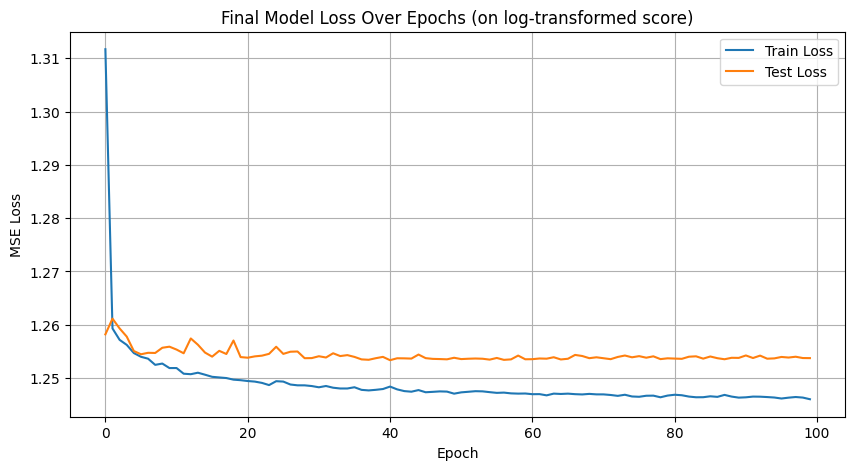

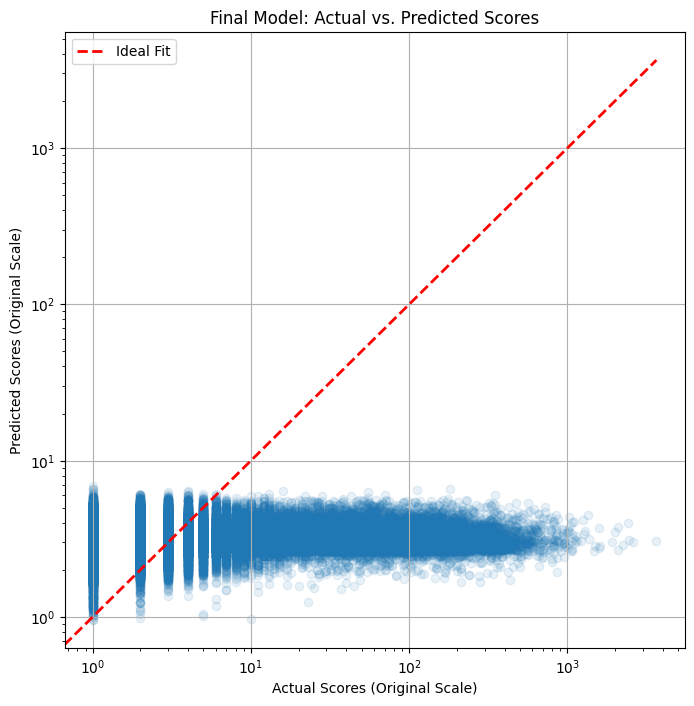

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
final_r2_score,▁
final_rmse,▁
final_test_loss,▆▄▅▇█▆▂▃▄▄▃▂▄▃▂▂▂▄▂▁▁▁▂▁▃▂▄▃▂▂▂▁▂▂▁▃▂▂▂▂
final_train_loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,99
final_r2_score,-0.03342
final_rmse,61.00354
final_test_loss,1.25373
final_train_loss,1.24601


In [32]:
# Final Training with Best Hyperparameters
if best_config:
    print("🚀 Training final model with best parameters...")
    
    # Initialize a new wandb run for the final model
    final_run = wandb.init(
        project="hackernews-score-predictor",
        name="final-training-with-best-params",
        config=best_config,
        tags=["final_model"]
    )
    
    # Dataloader, Model, Optimizer with best_config
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=best_config['batch_size'], shuffle=True)
    input_dim = X_train_scaled.shape[1]
    model = SimplePredictor(
        input_dim,
        layer_1_size=best_config['layer_1_size'],
        layer_2_size=best_config['layer_2_size'],
        dropout_rate=best_config['dropout_rate']
    ).to(device)

    if best_config['optimizer'] == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=best_config['learning_rate'], weight_decay=best_config['weight_decay'])
    elif best_config['optimizer'] == 'adamw':
        optimizer = optim.AdamW(model.parameters(), lr=best_config['learning_rate'], weight_decay=best_config['weight_decay'])
    else:
        optimizer = optim.SGD(model.parameters(), lr=best_config['learning_rate'], momentum=0.9, weight_decay=best_config['weight_decay'])

    criterion = nn.MSELoss()
    train_losses = []
    test_losses = []

    # Longer training for the final model
    for epoch in range(best_config['epochs']):
        model.train()
        epoch_train_loss = 0
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()

        # Evaluation
        model.eval()
        with torch.no_grad():
            test_outputs = model(X_test_tensor)
            test_loss = criterion(test_outputs, y_test_tensor).item()
        
        avg_train_loss = epoch_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        test_losses.append(test_loss)
        
        print(f"Epoch {epoch+1:2d}/{best_config['epochs']} | Train Loss: {avg_train_loss:.6f} | Test Loss: {test_loss:.6f}")
        wandb.log({"epoch": epoch, "final_train_loss": avg_train_loss, "final_test_loss": test_loss})
    
    print("\n🎉 Final model training complete!")
    
    # Final evaluation on original scale
    model.eval()
    with torch.no_grad():
        y_pred_log = model(X_test_tensor).cpu().numpy().flatten()
    
    y_pred_orig = np.expm1(y_pred_log)
    y_pred_orig[y_pred_orig < 0] = 0

    r2 = r2_score(y_test_orig, y_pred_orig)
    rmse = np.sqrt(mean_squared_error(y_test_orig, y_pred_orig))

    print(f"\nFINAL MODEL PERFORMANCE:")
    print(f"Test Set R² Score: {r2:.4f}")
    print(f"Test Set RMSE: {rmse:.2f}")
    wandb.log({"final_r2_score": r2, "final_rmse": rmse})

    # Plotting losses
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.title('Final Model Loss Over Epochs (on log-transformed score)')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.grid(True)
    wandb.log({"final_loss_plot": wandb.Image(plt)})
    plt.show()

    # Scatter plot
    plt.figure(figsize=(8, 8))
    plt.scatter(y_test_orig, y_pred_orig, alpha=0.1)
    plt.plot([y_test_orig.min(), y_test_orig.max()], [y_test_orig.min(), y_test_orig.max()], 'r--', lw=2, label='Ideal Fit')
    plt.xlabel('Actual Scores (Original Scale)')
    plt.ylabel('Predicted Scores (Original Scale)')
    plt.title('Final Model: Actual vs. Predicted Scores')
    plt.xscale('log')
    plt.yscale('log')
    plt.legend()
    plt.grid(True)
    wandb.log({"final_scatter_plot": wandb.Image(plt)})
    plt.show()
    
    final_run.finish()
else:
    print("❌ Final training skipped because no configuration was available.")